<a href="https://colab.research.google.com/github/Pavanbhargav13/IPL_WINNER-PREDICTION/blob/main/IPL_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [3]:
batting_df = pd.read_csv("all_season_batting_card.csv")
bowling_df = pd.read_csv("all_season_bowling_card.csv")

# ⚠️ THIS one has MATCH winners
summary_df = pd.read_csv("all_season_summary.csv")

# ⚠️ THIS one is the points table
points_df  = pd.read_csv("points_table.csv")


In [4]:
# ==============================
# CLEAN BATTING TABLE
# ==============================

batting = batting_df.copy()

# Fix season
batting["season"] = batting["season"].dropna().astype(int)

# Convert strike rate to numeric
batting["strikeRate"] = pd.to_numeric(
    batting["strikeRate"], errors="coerce"
)

# Rename batting team column
batting = batting.rename(columns={
    "current_innings": "team",
    "name": "player"
})

# Drop rows without essential data
batting = batting.dropna(
    subset=["team", "runs", "ballsFaced"]
)

# ==============================
# TEAM–SEASON AGGREGATION
# ==============================

batting_team = (
    batting
    .groupby(["season", "team"])
    .agg(
        total_runs=("runs", "sum"),
        avg_strike_rate=("strikeRate", "mean"),
        total_fours=("fours", "sum"),
        total_sixes=("sixes", "sum"),
        batting_depth=("player", "nunique")
    )
    .reset_index()
)

print(batting_team.head())
print(batting_team.shape)


   season  team  total_runs  avg_strike_rate  total_fours  total_sixes  \
0  2008.0   CSK      2365.0       115.002095        244.0         86.0   
1  2008.0    DC      2000.0       116.548400        218.0         54.0   
2  2008.0   KKR      1801.0       105.637545        162.0         75.0   
3  2008.0  KXIP      2340.0       120.280755        231.0         95.0   
4  2008.0    MI      1897.0       108.925490        197.0         76.0   

   batting_depth  
0             18  
1             15  
2             19  
3             19  
4             23  
(136, 7)


In [5]:
# ==============================
# CLEAN BOWLING TABLE
# ==============================

bowling = bowling_df.copy()

# Fix season
bowling["season"] = bowling["season"].dropna().astype(int)

# Convert economy rate to numeric
bowling["economyRate"] = pd.to_numeric(
    bowling["economyRate"], errors="coerce"
)

# Rename bowling team column
bowling = bowling.rename(columns={
    "bowling_team": "team",
    "name": "player"
})

# Drop rows without essential values
bowling = bowling.dropna(
    subset=["team", "wickets", "overs"]
)

# ==============================
# TEAM–SEASON AGGREGATION
# ==============================

bowling_team = (
    bowling
    .groupby(["season", "team"])
    .agg(
        total_wickets=("wickets", "sum"),
        avg_economy=("economyRate", "mean"),
        total_dots=("dots", "sum"),
        total_maidens=("maidens", "sum")
    )
    .reset_index()
)

print(bowling_team.head())
print(bowling_team.shape)


   season  team  total_wickets  avg_economy  total_dots  total_maidens
0  2008.0   CSK             83     8.581529         707              5
1  2008.0    DC             82     8.535976         637              2
2  2008.0   KKR             61     8.240533         567              2
3  2008.0  KXIP             83     8.884667         697              2
4  2008.0    MI             83     8.277955         640              3
(136, 6)


In [6]:
# ==============================
# MERGE TEAM FEATURES
# ==============================

team_features = batting_team.merge(
    bowling_team,
    on=["season", "team"],
    how="inner"
)

print(team_features.head())
print(team_features.shape)


   season  team  total_runs  avg_strike_rate  total_fours  total_sixes  \
0  2008.0   CSK      2365.0       115.002095        244.0         86.0   
1  2008.0    DC      2000.0       116.548400        218.0         54.0   
2  2008.0   KKR      1801.0       105.637545        162.0         75.0   
3  2008.0  KXIP      2340.0       120.280755        231.0         95.0   
4  2008.0    MI      1897.0       108.925490        197.0         76.0   

   batting_depth  total_wickets  avg_economy  total_dots  total_maidens  
0             18             83     8.581529         707              5  
1             15             82     8.535976         637              2  
2             19             61     8.240533         567              2  
3             19             83     8.884667         697              2  
4             23             83     8.277955         640              3  
(136, 11)


In [7]:
# ==============================
# CLEAN SUMMARY TABLE
# ==============================

summary = summary_df.copy()

# Fix season
summary["season"] = summary["season"].dropna().astype(int)

# Keep only rows with a winner
summary = summary.dropna(subset=["winner"])

# ==============================
# SEASON WINNERS (FINAL MATCH)
# ==============================

season_winners = (
    summary
    .groupby("season")["winner"]
    .last()   # final match winner of the season
    .reset_index()
    .rename(columns={"winner": "winner_team"})
)

print(season_winners.head())
print(season_winners.shape)


   season winner_team
0  2008.0          RR
1  2009.0         SRH
2  2010.0         CSK
3  2011.0         CSK
4  2012.0         KKR
(16, 2)


In [8]:
# Merge winner info into team_features
team_features = team_features.merge(
    season_winners,
    on="season",
    how="left"
)


| season | team | winner_team |
| ------ | ---- | ----------- |
| 2023   | CSK  | CSK         |
| 2023   | GT   | CSK         |
| 2023   | MI   | CSK         |
| 2023   | RR   | CSK         |


In [9]:
team_features["won_season"] = (
    team_features["team"] == team_features["winner_team"]
).astype(int)

# Drop helper column
team_features = team_features.drop(columns=["winner_team"])


In [10]:
print(team_features.groupby("season")["won_season"].sum())


season
2008.0    1
2009.0    1
2010.0    1
2011.0    1
2012.0    1
2013.0    1
2014.0    1
2015.0    1
2016.0    1
2017.0    1
2018.0    1
2019.0    1
2020.0    1
2021.0    1
2022.0    1
2023.0    1
Name: won_season, dtype: int64


In [11]:
print(team_features["won_season"].value_counts())


won_season
0    120
1     16
Name: count, dtype: int64


In [12]:
team_features[team_features["won_season"] == 1][
    ["season", "team"]
].sort_values("season").reset_index(drop=True)


,season,team
0,2008.0,RR
1,2009.0,SRH
2,2010.0,CSK
3,2011.0,CSK
4,2012.0,KKR
5,2013.0,MI
6,2014.0,KKR
7,2015.0,MI
8,2016.0,SRH
9,2017.0,MI


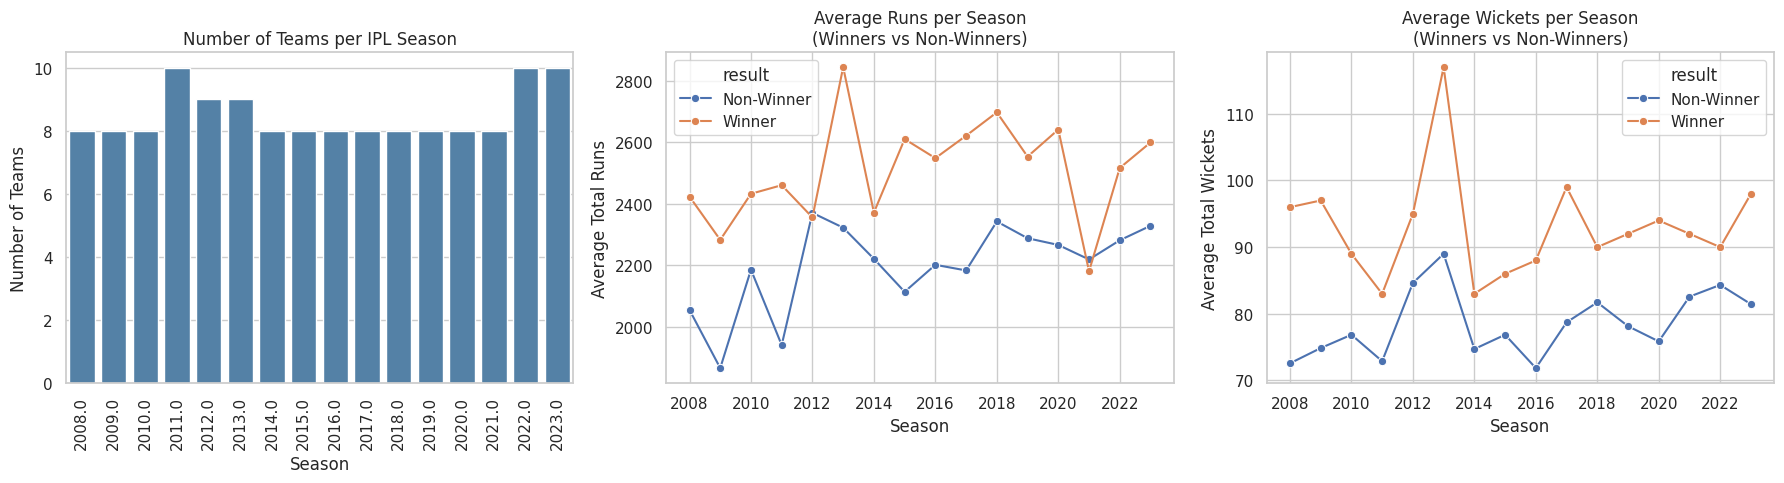

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

data = team_features.copy()

# Human-readable label
data["result"] = data["won_season"].map({0: "Non-Winner", 1: "Winner"})

plt.figure(figsize=(18, 5))

# ==================================================
# 1️⃣ NUMBER OF TEAMS PER SEASON (BAR PLOT)
# ==================================================
plt.subplot(1, 3, 1)

teams_per_season = (
    data.groupby("season")["team"]
    .nunique()
    .reset_index(name="num_teams")
)

sns.barplot(
    data=teams_per_season,
    x="season",
    y="num_teams",
    color="steelblue"
)

plt.title("Number of Teams per IPL Season")
plt.xlabel("Season")
plt.ylabel("Number of Teams")
plt.xticks(rotation=90)

# ==================================================
# 2️⃣ AVERAGE RUNS — WINNERS vs NON-WINNERS (LINE / SPIKE)
# ==================================================
plt.subplot(1, 3, 2)

avg_runs_season = (
    data.groupby(["season", "result"])["total_runs"]
    .mean()
    .reset_index()
)

sns.lineplot(
    data=avg_runs_season,
    x="season",
    y="total_runs",
    hue="result",
    marker="o"
)

plt.title("Average Runs per Season\n(Winners vs Non-Winners)")
plt.xlabel("Season")
plt.ylabel("Average Total Runs")

# ==================================================
# 3️⃣ AVERAGE WICKETS — WINNERS vs NON-WINNERS (LINE / SPIKE)
# ==================================================
plt.subplot(1, 3, 3)

avg_wickets_season = (
    data.groupby(["season", "result"])["total_wickets"]
    .mean()
    .reset_index()
)

sns.lineplot(
    data=avg_wickets_season,
    x="season",
    y="total_wickets",
    hue="result",
    marker="o"
)

plt.title("Average Wickets per Season\n(Winners vs Non-Winners)")
plt.xlabel("Season")
plt.ylabel("Average Total Wickets")

plt.tight_layout()
plt.show()


In [14]:
IPL_TITLES = {
    "CSK": 5, "MI": 5, "KKR": 2, "SRH": 1,
    "GT": 1, "RR": 1,
    "DC": 0, "RCB": 0, "PBKS": 0, "LSG": 0
}

team_features["titles_won"] = team_features["team"].map(IPL_TITLES)


| team | season |
| ---- | ------ |
| CSK  | 2023   |
| RCB  | 2023   |







| team | season | titles_won |
| ---- | ------ | ---------- |
| CSK  | 2023   | 5          |
| RCB  | 2023   | 0          |




DATA ENGINEERING

In [15]:
DROP_COLS = [
    "team",
    "won_season",      # target
    "rank",
    "matchpoints",
    "matcheswon",
    "matcheslost",
    "matchesplayed"
]

X = team_features.drop(columns=DROP_COLS, errors="ignore")
y = team_features["won_season"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (136, 11)
Target shape: (136,)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=42
)

print("Train winners:", y_train.sum())
print("Test winners:", y_test.sum())


Train winners: 12
Test winners: 4


In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=6,
                       min_samples_split=5, n_estimators=300, random_state=42)

In [18]:
from sklearn.metrics import classification_report

y_pred = rf_model.predict(X_test)

print("===== FINAL MODEL EVALUATION =====")
print(classification_report(y_test, y_pred, digits=3))


===== FINAL MODEL EVALUATION =====
              precision    recall  f1-score   support

           0      0.935     0.967     0.951        30
           1      0.667     0.500     0.571         4

    accuracy                          0.912        34
   macro avg      0.801     0.733     0.761        34
weighted avg      0.904     0.912     0.906        34



In [19]:
# ==============================
# IPL 2026 WINNING PROBABILITIES
# ==============================

latest_season = team_features["season"].max()

future_data = team_features[
    team_features["season"] == latest_season
].copy()

# Feature matrix must exactly match training columns
X_future = future_data[X.columns]

# Predict probabilities
probs = rf_model.predict_proba(X_future)[:, 1]

# Normalize to sum to 1
probs = probs / probs.sum()

future_data["win_probability_2026"] = probs

final_2026 = (
    future_data[["team", "win_probability_2026"]]
    .sort_values(by="win_probability_2026", ascending=False)
    .reset_index(drop=True)
)

print("🏆 IPL 2026 WINNING PROBABILITIES")
print(final_2026)


🏆 IPL 2026 WINNING PROBABILITIES
   team  win_probability_2026
0   CSK              0.421366
1    GT              0.274968
2    MI              0.191958
3   LSG              0.044209
4   RCB              0.025562
5    DC              0.017390
6    RR              0.010928
7   KKR              0.006083
8   SRH              0.005817
9  PBKS              0.001719


In [20]:
baseline_probs = final_2026.copy()
baseline_probs


,team,win_probability_2026
0,CSK,0.421366
1,GT,0.274968
2,MI,0.191958
3,LSG,0.044209
4,RCB,0.025562
5,DC,0.017390
6,RR,0.010928
7,KKR,0.006083
8,SRH,0.005817
9,PBKS,0.001719


In [21]:
def scenario_if_team_wins(
    baseline_df,
    winning_team,
    boost=0.15
):
    """
    Adjust probabilities assuming `winning_team` wins the season.

    boost: fraction of probability mass to boost the winner by
    """

    scenario = baseline_df.copy()

    prob_col = scenario.columns[1]

    # Original probability of the winning team
    original_prob = scenario.loc[
        scenario["team"] == winning_team, prob_col
    ].values[0]

    # Increase winner probability
    scenario.loc[
        scenario["team"] == winning_team, prob_col
    ] = original_prob * (1 + boost)

    # Reduce others proportionally
    mask = scenario["team"] != winning_team
    remaining_total = scenario.loc[mask, prob_col].sum()

    scale_factor = (
        1 - scenario.loc[scenario["team"] == winning_team, prob_col].values[0]
    ) / remaining_total

    scenario.loc[mask, prob_col] *= scale_factor

    # Final normalization (numerical safety)
    scenario[prob_col] = scenario[prob_col] / scenario[prob_col].sum()

    return scenario.sort_values(
        by=prob_col, ascending=False
    ).reset_index(drop=True)


In [24]:
scenario_srh = scenario_if_team_wins(
    baseline_probs,
    winning_team="SRH",
    boost=0.15
)

print("\n📌 SCENARIO: IF SRH WINS IPL 2026")
print(scenario_srh)



📌 SCENARIO: IF SRH WINS IPL 2026
   team  win_probability_2026
0   CSK              0.420996
1    GT              0.274727
2    MI              0.191790
3   LSG              0.044171
4   RCB              0.025539
5    DC              0.017375
6    RR              0.010918
7   SRH              0.006690
8   KKR              0.006078
9  PBKS              0.001717
